In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
pd.options.mode.chained_assignment = None  # Gets rid of the copy warning

# Create the dataframe
df = pd.read_csv('data/007_data.csv', skiprows=1)  # Change file to read in here
df_display = df.copy()


### Data Cleaning and Feature Engineering

In [2]:
# Turn all numeric columns from formatted strings into floats
df['Adjusted Revenue'] = df['Adjusted Revenue'].apply(lambda x:  1 if x == 'No Data'  else float(x.replace(',', '').replace('$','')))
df['US Box Office'] = df['US Box Office'].apply(lambda x: 1 if x == 'No Data'  else float(x.replace(',', '').replace('$','')))
df['International Revenue'] = df['International Revenue'].apply(lambda x: 1 if x == 'No Data'  else float(x.replace(',', '').replace('$','').strip(' (est.)')))
df['Average Rating'] = df['Average Rating'].apply(lambda x: float(x.replace('%', '')))
df['Metacritic'] = df['Metacritic'].apply(lambda x: float(x.replace('%', '')))
df['IMDb Rating'] = df['IMDb Rating'].apply(lambda x: float(x.replace(' / 10', '').replace(' (est.)', '')))
df['IMDb Rating'] = df['IMDb Rating'].apply(lambda x: x*10)

In [3]:
# Fill in 'No Data' entries with mean for column
for index, row in df.iterrows():
    if df['Adjusted Revenue'][index] == 1:
        df['Adjusted Revenue'][index] = df['Adjusted Revenue'].mean()
    if df['US Box Office'][index] == 1:
        df['US Box Office'][index] = df['US Box Office'].mean()
    if df['International Revenue'][index] == 1:
        df['International Revenue'][index] = df['International Revenue'].mean()

In [4]:
# Use qcut() to put adjusted revenue and Average Rating into 3 groups 
df['Revenue Category'] = pd.qcut(df['Adjusted Revenue'], q=3, labels=False)
df['Rating Category'] = pd.qcut(df['Average Rating'], q=3, labels=False)

# Add Changes to df_display (the formatted for viewing dataframe)
df_display[[ 'Revenue Category', 'Rating Category']] = df[['Revenue Category', 'Rating Category']]

# Change qcut numbers to qualatative categories in df_display
bin = {
    0: 'Low',
    1: 'Average',
    2: 'High'
}
df_display['Rating Category'] = df_display['Rating Category'].map(bin)  # Both map() and apply() do the same thing with different syntax
df_display['Revenue Category'] = df_display['Revenue Category'].apply(lambda x: 'Low' if x == 0 else ('Average' if x == 1 else 'High'))

### New Column Explanation
* Revenue Category classifes a movies earnings as high, average or low
* Rating Categoy classifies movie ratings as high, average or low
* These new columns will be predicted to test accuracy

In [5]:
df_display

Title  Year           Actor US Box Office  \
0                            Dr. No  1962    Sean Connery   $16,067,035   
1             From Russia with Love  1963    Sean Connery   $24,796,765   
2                        Goldfinger  1964    Sean Connery   $51,081,062   
3                       Thunderball  1965    Sean Connery   $63,595,658   
4               You Only Live Twice  1967    Sean Connery   $43,084,787   
5   On Her Majesty's Secret Service  1969  George Lazenby   $22,774,493   
6              Diamonds Are Forever  1971    Sean Connery   $43,819,547   
7                  Live and Let Die  1973     Roger Moore   $35,377,836   
8       The Man with the Golden Gun  1974     Roger Moore   $20,972,000   
9              The Spy Who Loved Me  1977     Roger Moore   $46,838,673   
10                        Moonraker  1979     Roger Moore   $70,308,099   
11               For Your Eyes Only  1981     Roger Moore   $54,812,802   
12                        Octopussy  1983     Roger Moore   $67,893,619   
13                 A View to a Kill  1985     Roger Moore   $50,327,960   
14             The Living Daylights  1987  Timothy Dalton   $51,185,897   
15                  License to Kill  1989  Timothy Dalton   $34,667,015   
16                        GoldenEye  1995  Pierce Brosnan  $106,429,941   
17              Tomorrow Never Dies  1997  Pierce Brosnan  $125,304,276   
18          The World Is Not Enough  1999  Pierce Brosnan  $126,943,684   
19                  Die Another Day  2002  Pierce Brosnan  $160,942,139   
20                    Casino Royale  2006    Daniel Craig  $167,445,960   
21                Quantum of Solace  2008    Daniel Craig  $168,368,427   
22                          Skyfall  2012    Daniel Craig  $304,360,277   
23                          Spectre  2015    Daniel Craig  $200,074,609   
24                   No Time to Die  2021    Daniel Craig  $155,582,117   

   International Revenue Adjusted Revenue Average Rating      IMDb Rating  \
0     $56,892,409 (est.)     $509,590,753          75.0%         7.2 / 10   
1     $87,803,860 (est.)     $778,757,111          79.0%         7.4 / 10   
2    $180,874,982 (est.)   $1,583,531,294          82.0%         7.7 / 10   
3    $225,188,418 (est.)   $1,940,194,814          67.0%           7 / 10   
4    $152,560,651 (est.)   $1,239,669,481          65.0%         6.9 / 10   
5     $80,643,116 (est.)     $596,363,534          64.0%         6.7 / 10   
6    $155,162,393 (est.)   $1,039,779,592          62.5%         6.6 / 10   
7    $125,270,799 (est.)     $765,731,866          61.5%         6.8 / 10   
8     $74,260,596 (est.)     $408,809,853          55.0%         6.7 / 10   
9    $165,852,937 (est.)     $742,780,315          63.0%         7.1 / 10   
10          $210,308,099     $786,193,086          64.5%         6.3 / 10   
11   $194,088,850 (est.)     $579,490,802          60.5%         6.7 / 10   
12   $240,407,240 (est.)     $655,085,592          64.0%         6.5 / 10   
13   $178,208,293 (est.)     $449,495,639          51.5%         6.3 / 10   
14   $181,246,197 (est.)     $433,012,481          63.5%         6.7 / 10   
15          $156,167,015     $341,804,257          62.0%         6.6 / 10   
16          $352,194,034     $627,201,187          68.5%         7.2 / 10   
17          $333,011,068     $563,110,304          58.5%         6.5 / 10   
18          $361,832,400     $589,443,658          60.5%         6.4 / 10   
19          $431,971,116     $651,678,493          58.5%         6.1 / 10   
20          $616,502,912     $829,954,813          80.0%         8.0 / 10   
21          $589,580,482     $743,205,494          62.0%         6.6 / 10   
22        $1,108,569,499   $1,310,390,950          79.5%         7.8 / 10   
23          $880,681,519   $1,008,510,398          64.0%         6.8 / 10   
24          $735,220,117     $735,220,117          68.0%  6.8 / 10 (est.)   

   Metacritic Revenue Category Rating Category  
0         78%              

### Display graphs of data to be predicted

The franchise has seen revenue decrease over time


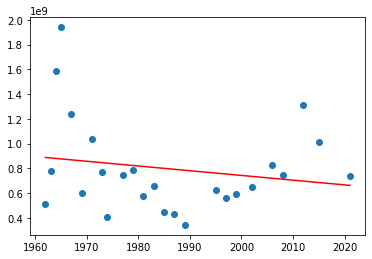

In [6]:
# Create the Revenue Plot
x = df['Year'].tolist()
y = df['Adjusted Revenue'].tolist()
plt.scatter(x, y)

# Create the Trendline
z = np.polyfit(x, y, 1)  # Gets values for trendline equation 
p = np.poly1d(z)  # Creates the trendline equation
plt.plot(x,p(x), color = 'red')

# Display the results
if z[0] > 0.05:
    print('The franchines has seen revenue increase over time')
elif z[0] < -0.05:
    print('The franchise has seen revenue decrease over time')
else:
    print('The franchise has maintained a consistent revenue over time')
plt.show()

The franchise has maintained a consistent quality over time


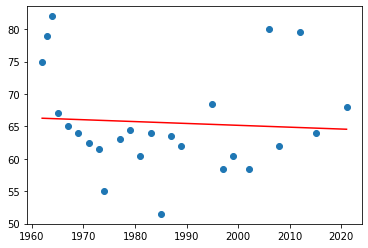

In [7]:
# Create the Average Review Score Plot
x = df['Year'].tolist()
y = df['Average Rating'].tolist()
plt.scatter(x, y)

# Create the Trendline
z = np.polyfit(x, y, 1)  # Gets values for trendline equation 
p = np.poly1d(z)  # Creates the trendline equation
plt.plot(x,p(x), color = 'red')

# Display the results
if z[0] > 0.05:
    print('The franchines has seen review scores improve over time')
elif z[0] < -0.05:
    print('The franchise has seen review scores decline over time')
else:
    print('The franchise has maintained a consistent quality over time')
plt.show()

### Test Prediction Models Against Revenue Category

In [8]:
# Use 1-hot encoding for the categorical features created by qcut()
df_rev = df.copy()
df_rev = pd.get_dummies(df_rev, columns=['Rating Category'], prefix = ['Rating'])
df_rev = df_rev.drop(['Title', 'Actor'], axis=1)

In [9]:
# Set X and Y for the training set
y = df_rev['Revenue Category']
df_rev = df_rev.drop(['Revenue Category'], axis=1)

# Scale the data
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
data_scaled = std_scaler.fit_transform(df_rev)

# Set the X for the training set
X = data_scaled

# Build the training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [10]:
# Create the KNN model
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

# Make predictions for 'Rating Category' and 'Revenue Category'
y_pred = knn.predict(X_test)

# Print the Accuracy score
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred) * 100
score = "{:,.2f}%".format(score)
print('Accuracy of Revenue Category Prediction using KNN: '+ score)

Accuracy of Revenue Category Prediction using KNN: 71.43%


In [11]:
# Create a DTC model
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=1)
clf.fit(X_train, y_train)

# Make the Prediction for 'Revenue Category'
y_pred2 = clf.predict(X_test)

# Print the results
score = accuracy_score(y_test, y_pred) * 100
score = "{:,.2f}%".format(score)
print('Accuracy of Revenue Category Prediction using DTC: '+ score)

Accuracy of Revenue Category Prediction using DTC: 71.43%


In [12]:
# Predict Revenue for Hypothetical Next Movie

### Test Prediction Models Against Ratings Category

In [13]:
# Use 1-hot encoding for the categorical features created by qcut()
df_rate = df.copy()
df_rate = pd.get_dummies(df_rate, columns=['Revenue Category'], prefix = ['Revenue'])
df_rate = df_rate.drop(['Title', 'Actor'], axis=1)

In [14]:
# Set Y for the training set
y2 = df_rate['Rating Category']
df_rate = df_rate.drop(['Rating Category'], axis=1)

# Scale the data
from sklearn.preprocessing import StandardScaler
std_scaler2 = StandardScaler()
data_scaled2 = std_scaler2.fit_transform(df_rate)

# Set the X for the training set
X2 = data_scaled2

# Build the training and test sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state=1)

In [15]:
# Create the KNN model
knn2 = KNeighborsClassifier(n_neighbors=2)
knn2.fit(X2_train, y2_train)

# Make predictions for 'Rating Category' and 'Revenue Category'
y2_pred = knn2.predict(X2_test)

# Print the Accuracy score
score = accuracy_score(y2_test, y2_pred) * 100
score = "{:,.2f}%".format(score)
print('Accuracy of Revenue Category Prediction using KNN: '+ score)

Accuracy of Revenue Category Prediction using KNN: 71.43%


In [16]:
# Create a DTC model
clf2 = DecisionTreeClassifier(random_state=1)
clf2.fit(X2_train, y2_train)

# Make the Prediction for 'Revenue Category'
y2_pred2 = clf2.predict(X2_test)

# Print the results
score = accuracy_score(y2_test, y2_pred) * 100
score = "{:,.2f}%".format(score)
print('Accuracy of Revenue Category Prediction using DTC: '+ score)

Accuracy of Revenue Category Prediction using DTC: 71.43%


In [17]:
# Predict the Rating Category of a Hypothetical Next Movie

### Conclusion

In [18]:
# Show the predicted Revenue and Rating of the Hypothetical Next Film